
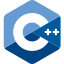
<br>

<div style="text-align:center; font-size:200%;">
 <b>Überladen von Operatoren</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Akademie München</div>
<br/>
<!-- 21 Überladen von Operatoren.ipynb -->
<!-- slides/module_190_standard_library/topic_135_operator_overloading.cpp -->


- Wir haben gesehen, dass man in C++ Funktionen überladen kann:

In [ ]:
#include <iostream>

In [ ]:
void f(int i) { std::cout << "f(int): " << i << "\n"; }

In [ ]:
void f(double d) { std::cout << "f(double): " << d << "\n"; }

In [ ]:
f(1);
f(1.0);


Viele Operatoren in C++ werden durch Funktionen implementiert, die überladen
werden können:

In [ ]:
namespace frac {
struct Fraction
{
    int numerator;
    int denominator;
};
}

In [ ]:
namespace frac {
Fraction operator*(Fraction lhs, Fraction rhs)
{
    return Fraction{lhs.numerator * rhs.numerator, lhs.denominator * rhs.denominator};
}
} // namespace frac

In [ ]:
frac::Fraction half{1, 2};
frac::Fraction third{1, 3};

In [ ]:
frac::Fraction result{third * half};

In [ ]:
std::cout << result.numerator << "/" << result.denominator << "\n";


Welche Operatoren können überladen werden?

- [Viele!](https://en.cppreference.com/w/cpp/language/operators)
  - Unäre Operatoren: `+`, `-`, `*`, `&`, `!`, `~`, `++`, `--`, ...
  - Binäre Operatoren: `+`, `-`, `&`, `<<`,`==`, `!=`, `<`, `=`, `+=`, `->`, ...
  - Funktionsaufruf- und Indexoperator: `()`, `[]`
  - Allokationssoperatoren: `new`, `new[]`, `delete`, `delete[]`
  - Typkonvertierungsoperatoren: `T()`
- Wichtige Ausnahmen:
  - Member-Zugriff: `.` (Keine Smart-References oder Properties!)
  - Gültigkeitsbereichsoperator: `::`


## Definition von Operatoren

- Operatoren können als Member-Funktionen oder als freie Funktionen
  definiert werden
- `=`, `->`, `()` und `[]` müssen als Member-Funktionen definiert werden
- Die anderen Operatoren werden typischerweise als freie Funktionen
  definiert
  - Oft als `friend`-Funktionen, um Zugriff auf private Member zu haben


## Beispiel: Polynome

Wir wollen eine Klasse für Polynome der Form

$$p(x) = a_0 + a_1 x + a_2 x^2 + \ldots + a_n x^n$$

implementieren.

- Die Koeffizienten $a_i$ sollen als `std::vector<double>` gespeichert
  werden
- Wir wollen den Funktionsaufruf-Operator `()` überladen, um Polynome
  auswerten zu können
- Wir wollen den Ausgabeoperator `<<` überladen, um Polynome ausgeben zu
  können

In [ ]:
#include <iostream>
#include <vector>

In [ ]:
namespace poly {
class Polynomial
{
public:
    Polynomial(std::vector<double> coefficients);

    double operator()(double x) const;

private:
    std::vector<double> coefficients_;
    friend std::ostream& operator<<(std::ostream& os, const Polynomial& p);
    friend Polynomial operator+(const Polynomial& lhs, const Polynomial& rhs);
};
} // namespace poly

In [ ]:
namespace poly {
Polynomial::Polynomial(std::vector<double> coefficients)
    : coefficients_{std::move(coefficients)}
{
    if (coefficients_.empty()) {
        throw std::invalid_argument{"Polynomial must have at least one coefficient"};
    }
    if (coefficients_.size() > 1 && coefficients_.back() == 0.0) {
        throw std::invalid_argument{"Leading coefficient must not be zero"};
    }
}
} // namespace poly

In [ ]:
namespace poly {
double Polynomial::operator()(double x) const
{
    double result{0};
    double power_of_x{1};
    for (const auto coeff : coefficients_) {
        result += coeff * power_of_x;
        power_of_x *= x;
    }
    return result;
}
} // namespace poly

In [ ]:
namespace poly {
void write_single_term(std::ostream& os, double coeff, int power, bool is_last_term)
{
    if (coeff != 0.0) {
        if (power == 0) {
            os << coeff;
        }
        else if (power == 1) {
            os << coeff << "x";
        }
        else {
            os << coeff << "x^" << power;
        }
        if (!is_last_term) {
            os << " + ";
        }
    }
    else if (is_last_term) {
        os << "0";
    }
}
} // namespace poly

In [ ]:
namespace poly {
std::ostream& operator<<(std::ostream& os, const Polynomial& p)
{
    int power{0};
    for (auto coeff : p.coefficients_) {
        bool is_last_term{power == p.coefficients_.size() - 1};
        write_single_term(os, coeff, power, is_last_term);
        ++power;
    }
    return os;
}
} // namespace poly

In [ ]:
#include <algorithm>

namespace poly {
Polynomial operator+(const Polynomial& lhs, const Polynomial& rhs)
{
    auto [smaller_size, larger_size]{
        std::minmax(lhs.coefficients_.size(), rhs.coefficients_.size())};

    std::vector<double> coefficients;
    coefficients.reserve(larger_size);

    for (std::size_t i{0}; i < smaller_size; ++i) {
        coefficients.push_back(lhs.coefficients_[i] + rhs.coefficients_[i]);
    }

    const auto& larger_poly{
        lhs.coefficients_.size() > rhs.coefficients_.size() ? lhs : rhs};
    for (std::size_t i{smaller_size}; i < larger_size; ++i) {
        coefficients.push_back(larger_poly.coefficients_[i]);
    }
    return Polynomial{coefficients};
}
} // namespace poly

In [ ]:
poly::Polynomial p1({1, 2, 0, 4, 3});

In [ ]:
std::cout << p1 << "\n";

In [ ]:
std::cout << p1(2) << "\n";

In [ ]:
poly::Polynomial p2({1, 2, 3});

In [ ]:
std::cout << p1 + p2 << "\n";

In [ ]:
std::cout << (p1 + p2)(4) << "\n";

In [ ]:
poly::Polynomial zero({0.0});
poly::Polynomial one({1.0});

In [ ]:
std::cout << zero << ", " << one << "\n";

In [ ]:
std::cout << zero(10) << ", " << one(10) << "\n";

In [ ]:
std::cout << p1 + zero << "\n";

In [ ]:
std::cout << zero + p1 << "\n";


## Mini-Workshop: Komplexe Zahlen

In diesem Workshop implementieren Sie eine Klasse für komplexe Zahlen.

Komplexe Zahlen kann man als Paar zweier `double`-Werte darstellen:
- Einen Realteil $x$
- Einen Imaginärteil $y$
- Man schreibt eine solche Zahl dann als $x + yi$


Die Rechenoperationen auf komplexen Zahlen sind wie folgt definiert:
- Addition: $(x + yi) + (u + vi) = (x + u) + (y + v)i$
- Subtraktion: $(x + yi) - (u + vi) = (x - u) + (y - v)i$
- Multiplikation: $(x + yi) \cdot (u + vi) = (xu - yv) + (xv + yu)i$


Implementieren Sie die Klasse `Complex` mit:
- Member-Variablen `real_` und `imag_`
- Einen Konstruktor, der Real- und Imaginärteil als Argumente nimmt
- Methoden `real()` und `imag()`, die Real- und Imaginärteil zurückgeben

In [ ]:
#include <iostream>

In [ ]:
namespace complex {
class Complex {
public:
    Complex(double real, double imag): real_(real), imag_(imag) {}

    double real() const { return real_; }
    double imag() const { return imag_; }

private:
    double real_;
    double imag_;
};
} // namespace complex

In [ ]:
namespace complex {
Complex operator+(const Complex& lhs, const Complex& rhs) {
    return Complex(lhs.real() + rhs.real(), lhs.imag() + rhs.imag());
}

Complex operator-(const Complex& lhs, const Complex& rhs) {
    return Complex(lhs.real() - rhs.real(), lhs.imag() - rhs.imag());
}

Complex operator*(const Complex& lhs, const Complex& rhs) {
    return Complex(lhs.real() * rhs.real() - lhs.imag() * rhs.imag(),
                   lhs.real() * rhs.imag() + lhs.imag() * rhs.real());
}
} // namespace complex


Implementieren Sie für die Klasse `Complex`:

- Operatoren für `+`, `-` und `*`
- Einen Ausgabeoperator `<<`
- Optional: Operatoren für `==` und `!=`// - Operators for `+`, `-` and `*`

Müssen Sie die Operatoren als Friend-Funktionen implementieren?

In [ ]:
namespace complex {
std::ostream& operator<<(std::ostream& os, const Complex& c) {
    os << c.real() << " + " << c.imag() << "i";
    return os;
}

bool operator==(const Complex& lhs, const Complex& rhs) {
    return lhs.real() == rhs.real() && lhs.imag() == rhs.imag();
}

bool operator!=(const Complex& lhs, const Complex& rhs) {
    return !(lhs == rhs);
}
} // namespace complex

*Antwort:* 
- Nein, die Operatoren benötigen keinen Zugriff auf private Member.

In [ ]:
complex::Complex i{0, 1};
complex::Complex j{1, 0};

In [ ]:
std::cout << i << ", " << j << "\n";

In [ ]:
std::cout << i + i << ", " << i + j << "\n";

In [ ]:
std::cout << i - j << "\n";

In [ ]:
std::cout << i * i << ", " << i * j << "\n";